In [1]:
import seaborn

# необходимые пакеты
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from scipy.sparse import hstack
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

train = pd.read_csv('train.csv').fillna(' ').sample(frac=1)
train.head(3)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
120997,875cdb3387663010,"""::::Here you go again with your condescension...",0,0,0,0,0,0
49032,8319766645f30783,Need consensus for changing the transliteratio...,0,0,0,0,0,0
147174,382438cb62ef3419,"I am not trolling, Friday... You could just ha...",0,0,0,0,0,0


Здесь много разных вариантов, но мы сведем все к бинарному классу - toxic/nontoxic

In [3]:
train['y'] = train[class_names].max(axis=1).values
train['y'].value_counts()

0    143346
1     16225
Name: y, dtype: int64

Сделаем тренировочную и тестовую выборки

In [4]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(train.drop('y', 1), 
                                                    train['y'], random_state=0)

Посмотрим на распределение классов в выборках

In [5]:
y_train.value_counts(normalize=True)

0    0.897467
1    0.102533
Name: y, dtype: float64

In [6]:
y_test.value_counts(normalize=True)

0    0.900885
1    0.099115
Name: y, dtype: float64

Построим простое векторное представление текстов и обучим логистическую регрессию

In [7]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]

classifier = Pipeline([('comment_text_selector', FeatureSelector(column='comment_text')), 
                     ('comment_text_tfidf', TfidfVectorizer(sublinear_tf=True,
                                                            strip_accents='unicode',
                                                            analyzer='word',
                                                            token_pattern=r'\w{1,}',
                                                            stop_words='english',
                                                            ngram_range=(1, 1),
                                                            max_features=1000)), 
                     ('clf', LogisticRegression(C=0.1, solver='sag'))])

#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=3, scoring='roc_auc')
cv_score = np.mean(cv_scores)
print('CV score is {}'.format(cv_score))

#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]

CV score is 0.9264592063613538


In [8]:
cv_scores

array([0.92509974, 0.92628321, 0.92799467])

Воспользуемся доступным в sklearn инструментарием, чтобы получить оптимальный порог

In [9]:
import numpy as np
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix

b=2.55

precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.101977, F-Score=0.720, Precision=0.381, Recall=0.835


Нарисуем roc кривую

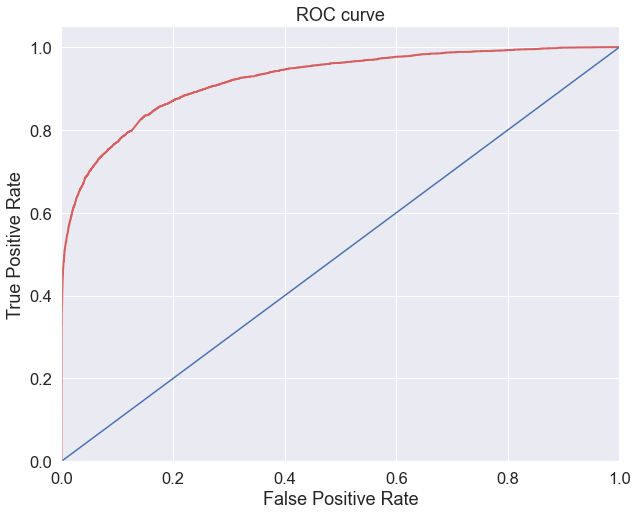

In [10]:
import seaborn as sns
import itertools
import matplotlib.pyplot as plt

%matplotlib inline
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw,color = 'r', label='ROC curve ')
#plt.plot(fpr1, tpr1, lw=1, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()

Как это интерпетировать? Давайте построим матрицу ошибок, чтобы стало понятнее

In [11]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[30582  5357]
 [  655  3299]]


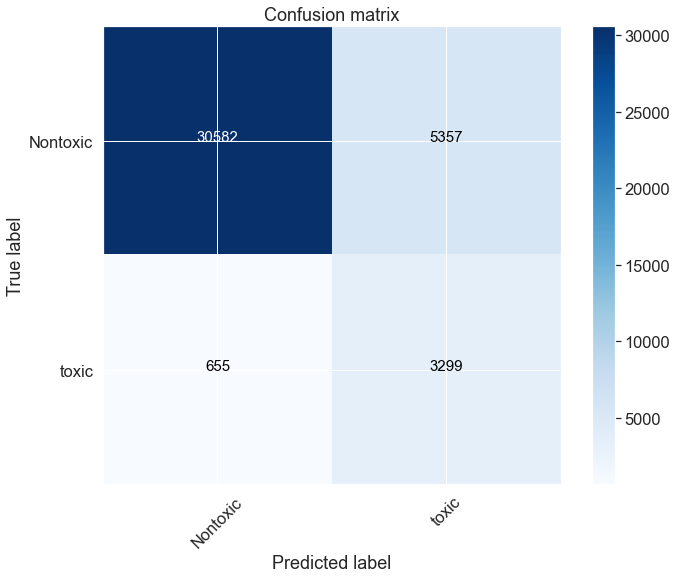

In [12]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, y_score>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Nontoxic', 'toxic'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Посчитаем FPR, TPR

In [13]:
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

Посчитаем нужные нам метрики

In [14]:
TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
TNR = TN/(FP+TN)
TPR, FPR, TNR

(0.8343449671219019, 0.14905812626951223, 0.8509418737304878)

False Positive Rate всего лишь 0.096.

Это означает, что только 9.6 процентов всех комментариев будут помечены как токсичные некорректно

Вывод:

Мы можем автоматически фильтровать 88 процентов токсичных комментариев! Однако есть еще TPR

Глобальные выводы:

1. TNR = 0.9 -> модель может автоматически фильтровать 90% токсичных комментариев
2. TPR = 0.88 -> доля ошибочно классифицированных как токсичных (хотя это нормальные комментарии), не будет превышать при этом 9.6 процентов

Что дальше? - планируем эксперимент!

### Кейс 2 - определение ССЗ

ссылка на соревнование - https://mlbootcamp.ru/ru/round/12/sandbox/

В рамках конкурса вам нужно предсказать наличие сердечно-сосудистых заболеваний по результатам классического врачебного осмотра. Датасет сформирован из 100.000 реальных клинических анализов, и в нём используются признаки, которые можно разбить на 3 группы:

 

Объективные признаки:

 - Возраст
 - Рост
 - Вес
 - Пол
 

Результаты измерения:

 - Артериальное давление верхнее и нижнее
 - Холестерин
 - Глюкоза
 

Субъективные признаки:

 - Курение
 - Употребление Алкоголя
 - Физическая активность
 

Возраст дан в днях. Значения показателей холестерина и глюкозы представлены одним из трех классов: норма, выше нормы, значительно выше нормы. Значения субъективных признаков — бинарны.

Все показатели даны на момент осмотра.

Таргет - наличие сердечно-сосудистых заболеваний (ССЗ)

In [15]:
df = pd.read_csv('train_case2.csv', ';')
df.head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


Разделим наши данные на тренировочную и тестовую выборки

In [16]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', 1), 
                                                    df['cardio'], random_state=0)

К полям:
- gender, cholesterol применим OHE-кодирование
- age, height, weight, ap_hi, ap_lo - standardScaler
- gluc, smoke, alco, active - оставим пока как есть

In [17]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]


from sklearn.preprocessing import StandardScaler


continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

Теперь объединим все наши трансформеры с помощью FeatureUnion

In [18]:
from sklearn.pipeline import FeatureUnion

feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[-1.73391771,  0.6873301 ,  0.74843904, ...,  1.        ,
         0.        ,  1.        ],
       [-1.67343538,  0.07758923, -0.29640123, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.13738132,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.17775864,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  1.        ],
       [-0.47190715, -1.38578883,  0.74843904, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.38174619,  0.56538192, -0.08743318, ...,  0.        ,
         0.        ,  1.        ]])

Добавим классификатор и запустим кросс-валидацию

In [19]:
classifier = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state = 42)),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]

CV score is 0.7867401104915408+-0.00852135511666111


Посчитаем precision/recall/f_score

In [20]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.386937, F-Score=0.730, Precision=0.647, Recall=0.838


Нарисуем roc auc кривую (кстати, наверное неплохо бы ее вынести в отдельную функцию)

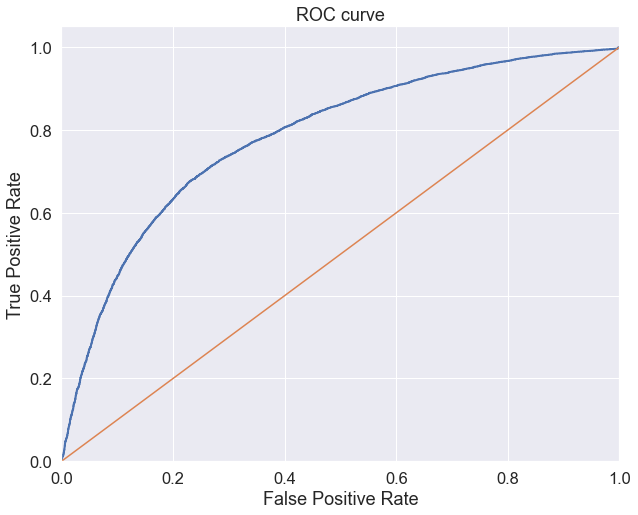

In [21]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()

In [22]:
from sklearn.metrics import roc_auc_score, log_loss

#Ваш код здесь
print("roc auc score: {}".format(roc_auc_score(y_true=y_test, y_score=classifier.predict_proba(X_test)[:,1])))
print("log loss score: {}".format(log_loss(y_true=y_test, y_pred=classifier.predict_proba(X_test)[:,1])))

#Ваш код здесь
print("roc auc score: {}".format(roc_auc_score(y_true=1-y_test, y_score=classifier.predict_proba(X_test)[:,0])))
print("log loss score: {}".format(log_loss(y_true=1-y_test, y_pred=classifier.predict_proba(X_test)[:,0])))

roc auc score: 0.7840347790421852
log loss score: 0.5779604008230663
roc auc score: 0.7840347790421852
log loss score: 0.5779603551317847


Посомтрим на матрицу ошибок

Confusion matrix, without normalization
[[4861 3959]
 [1411 7269]]


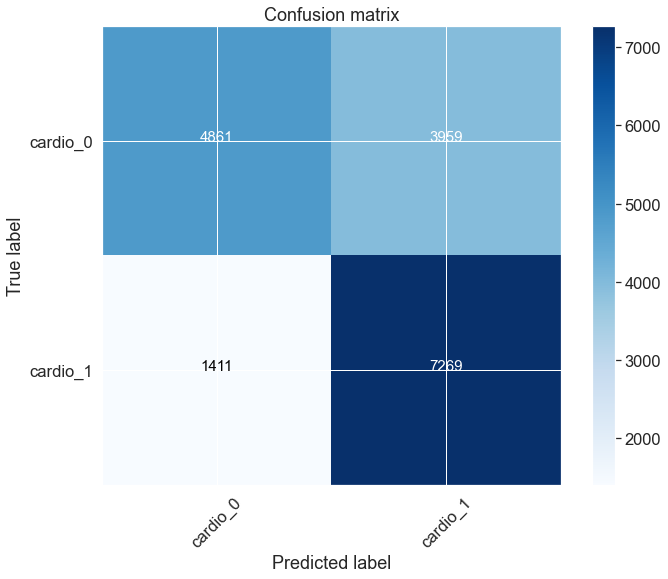

In [23]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

business_threshold = 1  # подберем порог для улучшения бизнесс показателя

cnf_matrix = confusion_matrix(y_test, y_score>thresholds[ix]*business_threshold)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Посчитаем FPR, TPR

In [24]:
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
TNR = TN/(FP+TN)
TPR, FPR, TNR

(0.837442396313364, 0.44886621315192743, 0.5511337868480726)

False Positive Rate довольно высокий ~ 0.45.

Это означает, что 45 процентов всех пациентов получат метку 1 при том, что они на самом деле здоровы

Хорошая ли модель у нас получилась? - ответ сильно зависит от внешних факторов (какое количество FP мы можем допустить)

#### Пусть:
 - стоимость лечения 15000 р, если сделали тест и начали лечить вовремя
 - стоимость лечения 20000, если упустили и начали лечить когда уже проявились все симптомы 
 - стоимость теста 1400 р
 
 
 
 - лишних тестов сделали FP = cnf_matrix[0][1]
 - пропустили больных FN = cnf_matrix[1][0]
 - правильных тестов сделали TP = cnf_matrix[1][1]

Оценим расходы, если не делать тест и ждать симптомов:

In [25]:
rubl_to_test = 1400
rubl_to_early_treatment = 15000
rubl_to_late_treatment = 20000

In [26]:
rubl_1 = (cnf_matrix[1][0]+cnf_matrix[1][1]) * rubl_to_late_treatment
print('расходы, если не делать тест и ждать симптомов:',rubl_1)

расходы, если не делать тест и ждать симптомов: 173600000


Расходы, если сделать тест всем:


In [27]:
rubl_all_test = np.sum(cnf_matrix) * rubl_to_test + (cnf_matrix[1][0]+cnf_matrix[1][1]) * rubl_to_early_treatment
print('расходы, если делать тест всем и лечить группу большых:',rubl_all_test)

расходы, если делать тест всем и лечить группу большых: 154700000


Расходы если использовать ML:

In [28]:
rubl_ML = (cnf_matrix[0][1]+cnf_matrix[1][1]) * rubl_to_test + (cnf_matrix[1][0]) * rubl_to_late_treatment + np.sum(cnf_matrix[1][1]) * rubl_to_early_treatment
print('расходы, если не делать тест и ждать симптомов:',rubl_ML)

расходы, если не делать тест и ждать симптомов: 152974200


Оценим разницу:


In [29]:
print(' Расходы при решении не делать тесты - расходы с МL :',rubl_1 - rubl_ML )
print(' Расходы при решении не делать тесты - расходы ссделать тесты всем  :',rubl_1 - rubl_all_test )
print(' Расходы сделать тесты всем - решение делать тесты ML  :',rubl_all_test - rubl_ML )

 Расходы при решении не делать тесты - расходы с МL : 20625800
 Расходы при решении не делать тесты - расходы ссделать тесты всем  : 18900000
 Расходы сделать тесты всем - решение делать тесты ML  : 1725800


Метрика по деньгам : получить меньше расходов чем при полном тесте

Расходы на тестирование всех и лечение при ранней диагностике - расходы на ML тест и лечение при ранней диагностике группы TP и поздней диагностике группы FN

In [61]:
def business_threshold_calibrate(y_test, y_score, thresholds,rubl_to_test = 100, rubl_to_early_treatment = 100, rubl_to_late_treatment = 1000):
    business_threshold = 0
    r1_r2_ = 0
    r1_r3_ = 0
    r2_r3_ = 0
    rubl_1_ = - 10000000 
    rubl_all_test_ = - 10000000 
    rubl_ML_ = - 10000000 

    r2 = []
    n = 20
    for opt_buisness_tr in np.linspace(0,1,n).tolist():
        # подберем порог для улучшения бизнесс показателя

        cnf_matrix = confusion_matrix(y_test, y_score > ( opt_buisness_tr))
        #print(cnf_matrix )
        rubl_1 = ((cnf_matrix[1][1]+cnf_matrix[1][0])) * rubl_to_late_treatment

        rubl_all_test = np.sum(cnf_matrix) * rubl_to_test + ((cnf_matrix[1][0]+cnf_matrix[1][1])) * rubl_to_early_treatment

        rubl_ML = ((cnf_matrix[1][1]+cnf_matrix[0][1])) * rubl_to_test + np.sum(cnf_matrix[1][0]) * rubl_to_late_treatment + (cnf_matrix[1][1]) * rubl_to_early_treatment
       
        r2_r3 = rubl_all_test - rubl_ML 
        
        r1_r2 = rubl_1 - rubl_all_test
        r1_r3 = rubl_1 - rubl_ML
        #print(opt_buisness_tr, r2_r3)
        if (r2_r3_ < r2_r3):
            
            business_threshold = opt_buisness_tr
            r1_r2_ = r1_r2
            r1_r3_ = r1_r3
            r2_r3_ = r2_r3
            rubl_1_ = rubl_1
            rubl_all_test_ = rubl_all_test
            rubl_ML_ = rubl_ML
            
        r2.append(r2_r3)   
            
    
    print('расходы, если не делать тест и ждать симптомов:',rubl_1_)
    print('расходы, если делать тест всем и лечить группу больных:',rubl_all_test_)
    print('расходы, если не делать тест и ждать симптомов:',rubl_ML_)
    print(' Расходы при решении не делать тесты - расходы с МL :',r1_r3_ )
    print(' Расходы при решении не делать тесты - расходы ссделать тесты всем  :',r1_r2_ )
    print(' Расходы сделать тесты всем - решение делать тесты ML  :',r2_r3_ )
    plt.plot(np.linspace(0,1,n),r2)
    plt.show()
    return business_threshold
    

расходы, если не делать тест и ждать симптомов: 173600000
расходы, если делать тест всем и лечить группу большых: 154700000
расходы, если не делать тест и ждать симптомов: 152712400
 Расходы при решении не делать тесты - расходы с МL : 20887600
 Расходы при решении не делать тесты - расходы ссделать тесты всем  : 18900000
 Расходы сделать тесты всем - решение делать тесты ML  : 1987600


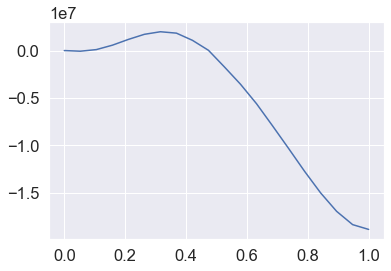

уровень порога по бизнес метрике 0.3157894736842105
уровень порога по f1 метрике 0.38693708911473634


In [31]:
BUisnes_tr = business_threshold_calibrate(y_test, y_score, 
                                          thresholds[ix] ,
                                          rubl_to_test = 1400, 
                                          rubl_to_early_treatment = 15000, 
                                          rubl_to_late_treatment = 20000)
print('уровень порога по бизнес метрике',BUisnes_tr)
print('уровень порога по f1 метрике',thresholds[ix])

### Домашнее задание

1. обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта
2. при обучении моделей обязательно использовать кроссвалидацию
3. вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score (можно в виде таблицы, где строки - модели, а столбцы - метрики)
4. сделать выводы о том, какая модель справилась с задачей лучше других
5. (опциональный вопрос) какая метрика (precision_recall_curve или roc_auc_curve) больше подходит в случае сильного дисбаланса классов? (когда объектов одного из классов намного больше чем другого). 

p.s.В вопросе проще разобраться, если вспомнить оси на графике roc auc curve и рассмотреть такой пример:

Имеется 100000 объектов, из которых только 100 - класс "1" (99900 - класс "0", соответственно). 
Допустим, у нас две модели:

- первая помечает 100 объектов как класс 1, но TP = 90
- вторая помечает 1000 объектов как класс 1, но TP такой же - 90

Какая модель лучше и почему? И что позволяет легче сделать вывод - roc_auc_curve или precision_recall_curve?

### Ссылки

1. https://dyakonov.org/2017/07/28/auc-roc-площадь-под-кривой-ошибок/
2. https://en.wikipedia.org/wiki/Receiver_operating_characteristic

In [92]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, auc

##### Обучим LogisticRegression

In [93]:
classifier = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state = 42)),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]

CV score is 0.7867401104915408+-0.00852135511666111


In [94]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.386937, F-Score=0.730, Precision=0.647, Recall=0.838


Запишем метрики

In [95]:
column_names = ['Model', 'Precisiion', 'Recall' , 'Fscore', 'CV Score', 'Auc']

result_df = pd.DataFrame(columns=column_names)
result_df
# 'LogisticRegression', 'RandomForest', 'GradientBoosting'],

,Model,Precisiion,Recall,Fscore,CV Score,Auc


функция добавления результатов

In [96]:
def append_result(df, model_name, col_names, rec, pre, fs, cvs, auc_score):
    app_df = pd.DataFrame([[model_name, rec, pre, fs, cvs, auc_score]], columns=col_names)
    df = df.append(app_df)
    return df

In [97]:
result_df = append_result(result_df,
                          'LogisticRegression',
                         column_names,
                         recall[ix],
                         precision[ix],
                         fscore[ix],
                         cv_score,
                         auc(recall, precision))
result_df

,Model,Precisiion,Recall,Fscore,CV Score,Auc
0,LogisticRegression,0.837558,0.647431,0.730323,0.78674,0.763165


расходы, если не делать тест и ждать симптомов: 173600000
расходы, если делать тест всем и лечить группу больных: 154700000
расходы, если не делать тест и ждать симптомов: 152712400
 Расходы при решении не делать тесты - расходы с МL : 20887600
 Расходы при решении не делать тесты - расходы ссделать тесты всем  : 18900000
 Расходы сделать тесты всем - решение делать тесты ML  : 1987600


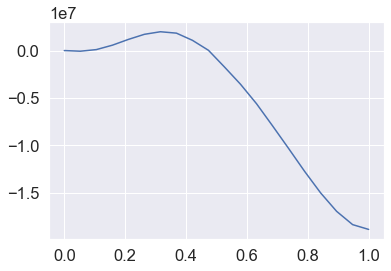

уровень порога по бизнес метрике 0.3157894736842105
уровень порога по f1 метрике 0.38693708911473634


In [98]:
BUisnes_tr = business_threshold_calibrate(y_test, y_score, 
                                          thresholds[ix] ,
                                          rubl_to_test = 1400, 
                                          rubl_to_early_treatment = 15000, 
                                          rubl_to_late_treatment = 20000)
print('уровень порога по бизнес метрике',BUisnes_tr)
print('уровень порога по f1 метрике',thresholds[ix])

##### Random Forest

In [99]:
classifier = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 42)),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]

CV score is 0.7734501681056019+-0.007171140345435727


In [100]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.350000, F-Score=0.719, Precision=0.643, Recall=0.816


In [101]:
result_df = append_result(result_df,
                          'RandomForest',
                         column_names,
                         recall[ix],
                         precision[ix],
                         fscore[ix],
                         cv_score,
                         auc(recall, precision))
result_df

,Model,Precisiion,Recall,Fscore,CV Score,Auc
0,LogisticRegression,0.837558,0.647431,0.730323,0.78674,0.763165
0,RandomForest,0.815553,0.642669,0.718863,0.77345,0.753756


расходы, если не делать тест и ждать симптомов: 173600000
расходы, если делать тест всем и лечить группу больных: 154700000
расходы, если не делать тест и ждать симптомов: 153132800
 Расходы при решении не делать тесты - расходы с МL : 20467200
 Расходы при решении не делать тесты - расходы ссделать тесты всем  : 18900000
 Расходы сделать тесты всем - решение делать тесты ML  : 1567200


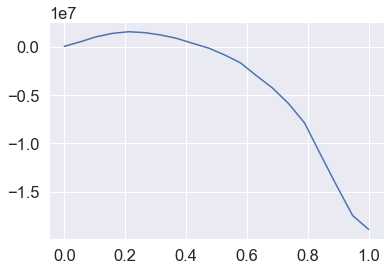

уровень порога по бизнес метрике 0.21052631578947367
уровень порога по f1 метрике 0.35


In [102]:
BUisnes_tr = business_threshold_calibrate(y_test, y_score, 
                                          thresholds[ix] ,
                                          rubl_to_test = 1400, 
                                          rubl_to_early_treatment = 15000, 
                                          rubl_to_late_treatment = 20000)
print('уровень порога по бизнес метрике',BUisnes_tr)
print('уровень порога по f1 метрике',thresholds[ix])

##### Gradient Boosting

In [103]:
classifier = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier(random_state = 42)),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]

CV score is 0.8025125910838183+-0.00707472977074522


In [104]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.394947, F-Score=0.740, Precision=0.698, Recall=0.788


In [105]:
result_df = append_result(result_df,
                          'GradientBoosting',
                         column_names,
                         recall[ix],
                         precision[ix],
                         fscore[ix],
                         cv_score,
                         auc(recall, precision))
result_df

,Model,Precisiion,Recall,Fscore,CV Score,Auc
0,LogisticRegression,0.837558,0.647431,0.730323,0.786740,0.763165
0,RandomForest,0.815553,0.642669,0.718863,0.773450,0.753756
0,GradientBoosting,0.788134,0.697848,0.740248,0.802513,0.783782


расходы, если не делать тест и ждать симптомов: 173600000
расходы, если делать тест всем и лечить группу больных: 154700000
расходы, если не делать тест и ждать симптомов: 152333600
 Расходы при решении не делать тесты - расходы с МL : 21266400
 Расходы при решении не делать тесты - расходы ссделать тесты всем  : 18900000
 Расходы сделать тесты всем - решение делать тесты ML  : 2366400


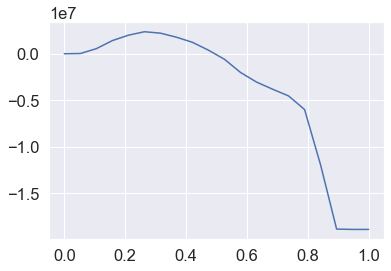

уровень порога по бизнес метрике 0.2631578947368421
уровень порога по f1 метрике 0.39494659702686624


In [108]:
BUisnes_tr = business_threshold_calibrate(y_test, y_score, 
                                          thresholds[ix] ,
                                          rubl_to_test = 1400, 
                                          rubl_to_early_treatment = 15000, 
                                          rubl_to_late_treatment = 20000)
print('уровень порога по бизнес метрике',BUisnes_tr)
print('уровень порога по f1 метрике',thresholds[ix])

,Model,Precisiion,Recall,Fscore,CV Score,Auc
0,LogisticRegression,0.837558,0.647431,0.730323,0.786740,0.763165
0,RandomForest,0.815553,0.642669,0.718863,0.773450,0.753756
0,GradientBoosting,0.788134,0.697848,0.740248,0.802513,0.783782


<Figure size 432x288 with 0 Axes>

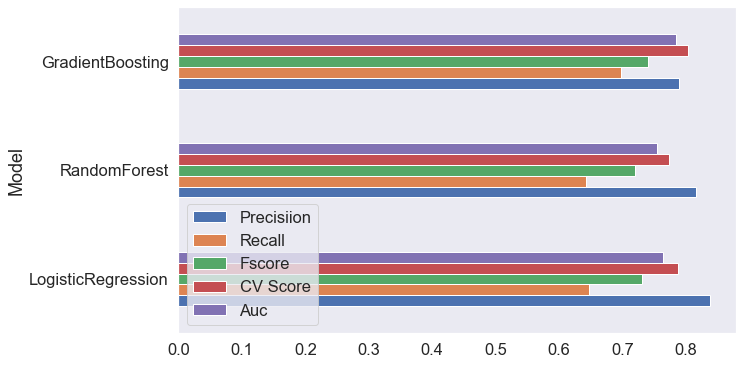

In [109]:
plt.figure()
result_df.set_index('Model').plot(kind='barh', figsize=(10, 6))
plt.legend(loc=3)
plt.grid()
result_df

##### Выводы
Лучше всего себя показывает модель градиентного бустинга, т.к. показывает лучшие результаты (за исключением precision)

Имеется 100000 объектов, из которых только 100 - класс "1" (99900 - класс "0", соответственно). 
Допустим, у нас две модели:

- первая помечает 100 объектов как класс 1, но TP = 90
- вторая помечает 1000 объектов как класс 1, но TP такой же - 90

Какая модель лучше и почему? И что позволяет легче сделать вывод - roc_auc_curve или precision_recall_curve?

##### Для проверки создадим датасет с заданным дисбалансом классов

In [116]:
from sklearn.datasets import make_classification

In [118]:
X_exp, y_exp = make_classification(n_samples=100000, n_classes=2, weights=[0.999,0.01], random_state=1)

In [119]:
X_train_exp, X_test_exp, y_train_exp, y_test_exp = train_test_split(X_exp, y_exp, random_state=42)

##### Обучим для быстроты логистическую регрессию

In [121]:
classifier = Pipeline([
#     ('features',feats),
    ('classifier', LogisticRegression(random_state = 42)),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train_exp, y_train_exp, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train_exp, y_train_exp)
y_score = classifier.predict_proba(X_test_exp)[:, 1]

CV score is 0.7219631569168042+-0.049595102961642976


In [127]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test_exp, y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.103577, F-Score=0.313, Precision=0.338, Recall=0.291


Confusion matrix, without normalization
[[24644   129]
 [  162    65]]


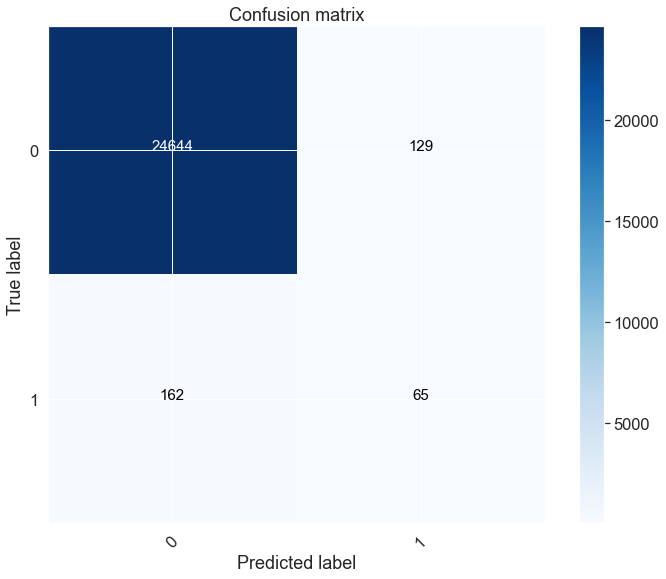

In [139]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

business_threshold = 1  # подберем порог для улучшения бизнесс показателя

cnf_matrix = confusion_matrix(y_test_exp, y_score>thresholds[ix]*business_threshold)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['0', '1'],
                      title='Confusion matrix')
plt.show()

Из матрицы видно, что модель хорошо предсказывает класс 0, и хуже класс 1

##### График ROC curve

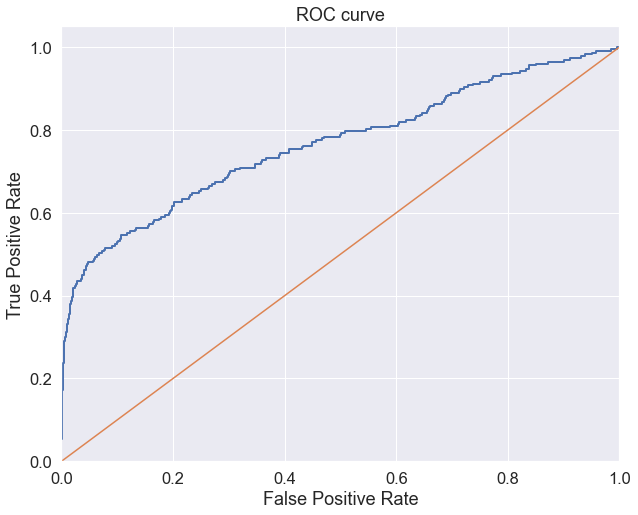

In [129]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds_ = roc_curve(y_test_exp, y_score, pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

##### График PR curve

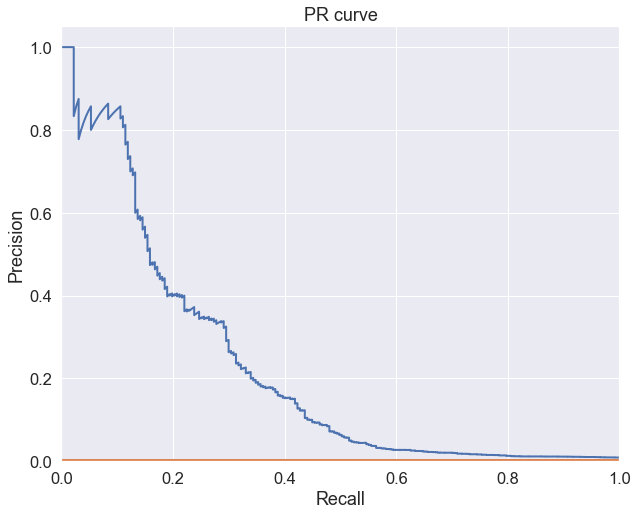

In [137]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds_ = roc_curve(y_test_exp, y_score, pos_label=1)
lw = 2
plt.plot(recall, precision, lw=lw, label='PR curve ')
plt.plot([0, 1], [0, 0], linewidth=5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR curve')
plt.show()

##### CV ROC AUC score VS AUC score

In [132]:
cv_score, auc(recall, precision)

(0.7219631569168042, 0.22177112703336155)

##### Вывод:
Для датасетов с большим дисбалансом классов больше подходит precision-recall curve. Т.к. в данном случае мы "учитываем" только классы 1 (TP, FP, TN) и нам не важны классы 0. То есть мы получаем реальную картину работы модели по предсказанию именно класса 1. В свою очередь ROC AUC curve в FPR учитывает TRUE NEGATIVE. Значит модель, предсказывающая хорошо объекты класса 0, которые в нашем случае не так важны из-за дисбаланса классов, будет иметь высокий результат.